In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import boundary
from boundary.attributions import PT_IntegratedGradient
from boundary import BA_tensorflow
import trulens.nn.backend as B
B.channel_axis = 3
B.dim_order = 'channels_last'

from trulens.visualizations import Visualizer, HeatmapVisualizer, MaskVisualizer

import os
os.environ['TRULENS_BACKEND'] = 'tf.keras'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

tf.keras.backend.set_image_data_format('channels_last')

Pytorch backend or Captum is not found.
Successfully import Tensorflow


## Load an example image

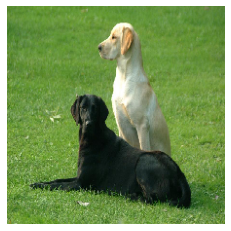

In [2]:
img = tf.keras.preprocessing.image.load_img(
    "dogs.jpg", grayscale=False, color_mode='rgb', target_size=(224, 224),
    interpolation='nearest')
plt.imshow(img)
plt.axis("off")
plt.show()

## Preprocess the input

In [3]:
# We will use tf.keras.application models. The following is the standard preprocessing.
X = tf.keras.preprocessing.image.img_to_array(img)[None, :]
print(f"X's shape is {X.shape}")

X = tf.keras.applications.resnet_v2.preprocess_input(
    X, data_format=None
)
print(f"X max: {X.max()}, X min: {X.min()}")

X's shape is (1, 224, 224, 3)
X max: 1.0, X min: -1.0


## Load a Tensorflow Model

In [4]:
model = tf.keras.applications.ResNet50V2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), pooling=None, classes=1000)

In [5]:
pred = np.argmax(model.predict(X), -1)
print("Prediction: ", pred)
# 208: 'Labrador retriever'

Prediction:  [208]


In [6]:
n_classes = 1000
labels_onehot = np.squeeze(np.eye(n_classes)[pred.reshape(-1)])[None,:]

## Compute Attributions

In [17]:
#Wrap the Integrated Gradient with BA_pytorch Wrapper
big = BA_tensorflow('BIG', use_boundary=True)

In [21]:
parameters = boundary.PARAMETERS
parameters['n_steps'] = 50
parameters['data_min'] = -1.0
parameters['data_max'] = 1.0

print(">>> Parameters of the model ....")
for k in parameters.keys():
    print(f"{k}: {parameters[k]}")
print("\n")
pipeline = boundary.PIPELINE
# If you want to modify the default parameters
pipeline['pgd_eps'] = np.array([36/255., 64/255., 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3])
pipeline['pgd_max_steps'] = 100
pipeline['methods'] = 'PGDs'

print(">>> Parameters of Pipeline ....")
for k in pipeline.keys():
    print(f"{k}: {pipeline[k]}")

>>> Parameters of the model ....
batch_size: 32
data_min: -1.0
data_max: 1.0
device: cuda:0
n_steps: 50
stdevs: 0.15


>>> Parameters of Pipeline ....
methods: PGDs
norm: l2
pgd_eps: [0.14117647 0.25098039 0.3        0.5        0.7        0.9
 1.         1.1        1.3       ]
pgd_step_size: None
pgd_max_steps: 100
cw_eps: 1.0
cw_step_size: 0.01
cw_max_steps: 100


In [22]:
attr = big.attribute(model,
                     X,
                     labels_onehot,
                     pipline=pipeline,
                     return_dis=False,
                     backend='tf.keras',
                     **parameters)

>>> Start PGD Attack <<<
  0%|          | 0/1 [00:00<?, ?it/s]>>> Attacking with EPS=0.1411764705882353 (norm=l2), Success Rate=0.0 <<<
>>> Attacking with EPS=0.25098039215686274 (norm=l2), Success Rate=0.0 <<<
>>> Attacking with EPS=0.3 (norm=l2), Success Rate=0.0 <<<
>>> Attacking with EPS=0.5 (norm=l2), Success Rate=1.0 <<<
>>> Attacking with EPS=0.7 (norm=l2), Success Rate=1.0 <<<
>>> Attacking with EPS=0.9 (norm=l2), Success Rate=1.0 <<<
>>> Attacking with EPS=1.0 (norm=l2), Success Rate=1.0 <<<
>>> Attacking with EPS=1.1 (norm=l2), Success Rate=1.0 <<<
100%|██████████| 1/1 [00:15<00:00, 15.87s/it]


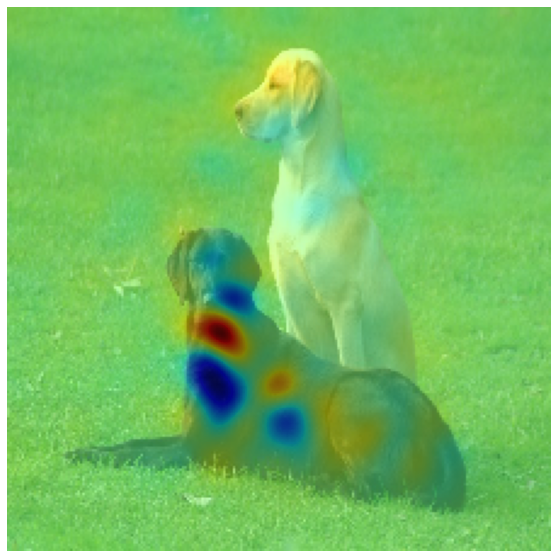

In [23]:
mask_viz = HeatmapVisualizer(blur=7, normalization_type="signed_max")
img = (X + 1.0) / 2.0 

fig = plt.figure(figsize=(10,10))
_ = mask_viz(attr, img, overlay_opacity=0.5, fig=fig, return_tiled=False) 